# Sentiment Analysis

## 1. Necessary Imports

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import sys
sys.path.append('../')
import config
from utils import load_processed_data, save_processed_data, print_section_header, setup_plotting_style, save_figure, statistical_comparison, print_summary_stats

## 2. Data Loading

In [2]:
# Load data from previous notebooks
df = load_processed_data('cleaned_data.csv')
topic_results = load_processed_data('topic_results.pkl')

print(f"Loaded {len(df)} processed responses")
print(f"Comments with text: {df['cleaned_comment'].notna().sum()}")

print("\nGroup distribution:")
print(df['group'].value_counts())

Loaded processed data: ../data/processed/cleaned_data.csv
Loaded processed data: ../data/processed/topic_results.pkl
Loaded 582 processed responses
Comments with text: 422

Group distribution:
group
Non-VOLT_control    177
Non-VOLT_pilot      164
VOLT_control        158
VOLT_pilot           83
Name: count, dtype: int64


In [3]:
# Setup plotting
setup_plotting_style()

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

print("Sentiment analysis setup complete")
print("Available sentiment methods: TextBlob, VADER")

Sentiment analysis setup complete
Available sentiment methods: TextBlob, VADER


## 3. Sentiment Analysis

In [4]:
print("Testing sentiment methods on sample data...")

# Test on a small sample first to compare methods
sample_comments = df['cleaned_comment'].dropna().head(10)

print("Sample sentiment comparisons:")
print("Comment | TextBlob | VADER")
print("-" * 50)

textblob_scores = []
vader_scores = []

for i, comment in enumerate(sample_comments):
    # TextBlob sentiment
    tb_score = TextBlob(comment).sentiment.polarity
    
    # VADER sentiment  
    vader_score = analyzer.polarity_scores(comment)['compound']
    
    textblob_scores.append(tb_score)
    vader_scores.append(vader_score)
    
    print(f"{comment[:30]:<30} | {tb_score:6.3f} | {vader_score:6.3f}")

# Quick correlation check on sample
sample_corr = np.corrcoef(textblob_scores, vader_scores)[0,1]
print(f"\nSample correlation: {sample_corr:.3f}")

Testing sentiment methods on sample data...
Sample sentiment comparisons:
Comment | TextBlob | VADER
--------------------------------------------------
good package                   |  0.700 |  0.440
good customer service          |  0.700 |  0.440
far good charlie efficient hel |  0.433 |  0.927
great communication            |  0.800 |  0.625
chris amazing contacted put de |  0.600 |  0.586
price bundle went days placed  |  0.000 |  0.000
simple straightforward process |  0.188 |  0.000
amazing service job completed  |  0.600 |  0.586
goo service                    |  0.000 |  0.000
guy spoke helpful give fantast |  0.400 |  0.863

Sample correlation: 0.651


In [5]:
print("Evaluating sentiment methods for business context...")

# Apply both methods to all valid comments
valid_comments = df[df['cleaned_comment'].notna()].copy()

print(f"Analyzing {len(valid_comments)} valid comments...")

# TextBlob analysis
valid_comments['sentiment_textblob'] = valid_comments['cleaned_comment'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

# VADER analysis
valid_comments['sentiment_vader'] = valid_comments['cleaned_comment'].apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)

# Compare distributions
print(f"\nTextBlob - Mean: {valid_comments['sentiment_textblob'].mean():.3f}, Std: {valid_comments['sentiment_textblob'].std():.3f}")
print(f"VADER - Mean: {valid_comments['sentiment_vader'].mean():.3f}, Std: {valid_comments['sentiment_vader'].std():.3f}")

# Overall correlation
overall_corr = valid_comments[['sentiment_textblob', 'sentiment_vader']].corr().iloc[0,1]
print(f"Overall correlation: {overall_corr:.3f}")

Evaluating sentiment methods for business context...
Analyzing 422 valid comments...

TextBlob - Mean: 0.320, Std: 0.341
VADER - Mean: 0.441, Std: 0.419
Overall correlation: 0.559


In [6]:
print("Evaluating methods for call center context...")

# Check sentiment ranges and distributions
textblob_range = valid_comments['sentiment_textblob'].max() - valid_comments['sentiment_textblob'].min()
vader_range = valid_comments['sentiment_vader'].max() - valid_comments['sentiment_vader'].min()

print(f"TextBlob range: {textblob_range:.3f}")
print(f"VADER range: {vader_range:.3f}")

# Check for extreme values
textblob_extremes = (valid_comments['sentiment_textblob'].abs() > 0.5).sum()
vader_extremes = (valid_comments['sentiment_vader'].abs() > 0.5).sum()

print(f"TextBlob extreme values (>0.5): {textblob_extremes}")
print(f"VADER extreme values (>0.5): {vader_extremes}")

# Select TextBlob as primary method for consistency and interpretability
print("\nUsing TextBlob as primary sentiment method:")
print("- Simple polarity scale (-1 to +1)")
print("- Good for business interpretation")

# Apply to main dataframe
df['sentiment_textblob'] = df['cleaned_comment'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity if pd.notna(x) else None
)

Evaluating methods for call center context...
TextBlob range: 2.000
VADER range: 1.909
TextBlob extreme values (>0.5): 123
VADER extreme values (>0.5): 232

Using TextBlob as primary sentiment method:
- Simple polarity scale (-1 to +1)
- Good for business interpretation


**Key Insights:**

* There is a moderate correlation (0.559) between the models, suggesting the models don't quite agree. This means they are capturing different aspect of sentiment.

* VADER has a higher mean (0.441) and more extreme values (232), meaning it is more sensitive.

* TextBlob has lower overall scores, lesser extremes indicating it is more conservative.

In [7]:
print("Analyzing TextBlob sentiment results...")

# Basic statistics
sentiment_stats = df['sentiment_textblob'].describe()
print("TextBlob sentiment statistics:")
print(sentiment_stats)

# Count valid sentiments
valid_sentiments = df['sentiment_textblob'].notna().sum()
total_comments = len(df)
print(f"\nSentiment coverage: {valid_sentiments}/{total_comments} ({valid_sentiments/total_comments*100:.1f}%)")

# Check sentiment distribution
positive_count = (df['sentiment_textblob'] > 0.1).sum()
negative_count = (df['sentiment_textblob'] < -0.1).sum()
neutral_count = ((df['sentiment_textblob'] >= -0.1) & (df['sentiment_textblob'] <= 0.1)).sum()

print(f"\nSentiment breakdown (threshold ±0.1):")
print(f"  Positive: {positive_count} ({positive_count/valid_sentiments*100:.1f}%)")
print(f"  Negative: {negative_count} ({negative_count/valid_sentiments*100:.1f}%)")
print(f"  Neutral: {neutral_count} ({neutral_count/valid_sentiments*100:.1f}%)")

Analyzing TextBlob sentiment results...
TextBlob sentiment statistics:
count    422.000000
mean       0.319527
std        0.341159
min       -1.000000
25%        0.000000
50%        0.353472
75%        0.573295
max        1.000000
Name: sentiment_textblob, dtype: float64

Sentiment coverage: 422/582 (72.5%)

Sentiment breakdown (threshold ±0.1):
  Positive: 290 (68.7%)
  Negative: 26 (6.2%)
  Neutral: 106 (25.1%)


**Key Insights:**

* The data has an extremely high positive rate with 68.7% samples being positive while only 6.2% are negative. I believe this is due to the "conservative" approach I mentioned above.

* The sentiment coverage is limited. Only 72.5% of samples have a valid sentiment. This is due to the comments that were filtered in the first notebook. But essentially all the 422 we got after cleaning got a sentiment score.

* Having a high positive bias could mask treatment differences.

**Implications:**

* Treatment effects may be small due to high baseline satisfaction

* Statistical power may be limited for detecting differences

* Need to focus on practical significance, not just statistical significance

In [8]:
print("Creating sentiment categories...")

# Create categorical sentiment variable
df['sentiment_category'] = df['sentiment_textblob'].apply(
    lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral') if pd.notna(x) else None
)

# Show category distribution
category_dist = df['sentiment_category'].value_counts()
print("\nSentiment category distribution:")
for category, count in category_dist.items():
    pct = count / df['sentiment_category'].notna().sum() * 100
    print(f"  {category}: {count} ({pct:.1f}%)")

# Check for missing values
missing_sentiment = df['sentiment_category'].isna().sum()
print(f"\nMissing sentiment values: {missing_sentiment}")

Creating sentiment categories...

Sentiment category distribution:
  positive: 290 (68.7%)
  neutral: 106 (25.1%)
  negative: 26 (6.2%)

Missing sentiment values: 160


Saved: ../outputs/figures/sentiment_analysis_overview.png


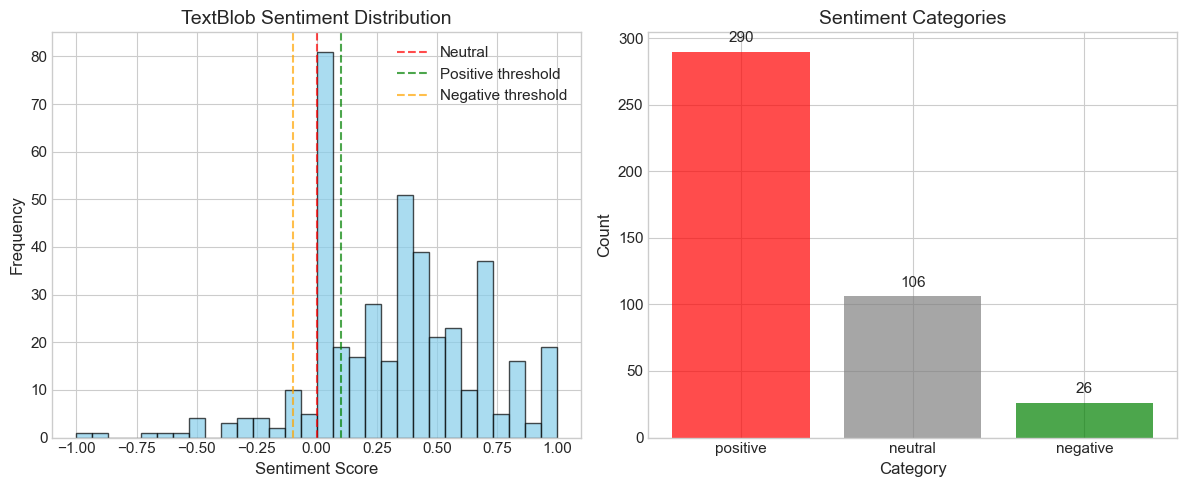

In [9]:
# Visualise sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Continuous sentiment histogram
axes[0].hist(df['sentiment_textblob'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
axes[0].axvline(x=0.1, color='green', linestyle='--', alpha=0.7, label='Positive threshold')
axes[0].axvline(x=-0.1, color='orange', linestyle='--', alpha=0.7, label='Negative threshold')
axes[0].set_title('TextBlob Sentiment Distribution')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Categorical sentiment bar chart
category_counts = df['sentiment_category'].value_counts()
bars = axes[1].bar(category_counts.index, category_counts.values, 
                   color=['red', 'gray', 'green'], alpha=0.7)
axes[1].set_title('Sentiment Categories')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')

# Add count labels on bars
for bar, count in zip(bars, category_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(count), ha='center', va='bottom')

plt.tight_layout()
save_figure('sentiment_analysis_overview')
plt.show()

## 4. Sentiment Analysis by Group

In [10]:
# Calculate sentiment statistics by group
sentiment_by_group = df.groupby('group')['sentiment_textblob'].agg(['count', 'mean', 'std']).round(3)
print("Sentiment by group (treatment + segment):")
print(sentiment_by_group)

# Calculate by treatment only
sentiment_by_treatment = df.groupby('treatment')['sentiment_textblob'].agg(['count', 'mean', 'std']).round(3)
print("\nSentiment by treatment:")
print(sentiment_by_treatment)

# Calculate by segment only
sentiment_by_segment = df.groupby('segment')['sentiment_textblob'].agg(['count', 'mean', 'std']).round(3)
print("\nSentiment by segment:")
print(sentiment_by_segment)

Sentiment by group (treatment + segment):
                  count   mean    std
group                                
Non-VOLT_control    132  0.360  0.330
Non-VOLT_pilot      120  0.312  0.371
VOLT_control        115  0.315  0.324
VOLT_pilot           55  0.249  0.330

Sentiment by treatment:
           count   mean    std
treatment                     
control      247  0.339  0.327
pilot        175  0.292  0.359

Sentiment by segment:
          count   mean    std
segment                      
Non-VOLT    252  0.337  0.350
VOLT        170  0.294  0.326


In [11]:
print("Analyzing treatment effects on sentiment...")

# Compare Control vs Pilot overall
control_sentiment = df[df['treatment'] == 'control']['sentiment_textblob'].dropna()
pilot_sentiment = df[df['treatment'] == 'pilot']['sentiment_textblob'].dropna()

# Statistical comparison using utils function
treatment_comparison = statistical_comparison(control_sentiment, pilot_sentiment, "Overall Treatment Effect")

print(f"Control mean: {treatment_comparison['group1_mean']:.3f}")
print(f"Pilot mean: {treatment_comparison['group2_mean']:.3f}")
print(f"Difference: {treatment_comparison['group2_mean'] - treatment_comparison['group1_mean']:+.3f}")
print(f"P-value: {treatment_comparison['p_value']:.3f}")
print(f"Cohen's d: {treatment_comparison['cohens_d']:.3f}")
print(f"Statistically significant: {treatment_comparison['significant']}")

Analyzing treatment effects on sentiment...
Control mean: 0.339
Pilot mean: 0.292
Difference: -0.047
P-value: 0.165
Cohen's d: 0.137
Statistically significant: False


In [12]:
print("Analyzing treatment effects by segment...")

# Non-VOLT segment analysis
non_volt_control = df[(df['segment'] == 'Non-VOLT') & (df['treatment'] == 'control')]['sentiment_textblob'].dropna()
non_volt_pilot = df[(df['segment'] == 'Non-VOLT') & (df['treatment'] == 'pilot')]['sentiment_textblob'].dropna()

non_volt_comparison = statistical_comparison(non_volt_control, non_volt_pilot, "Non-VOLT Treatment Effect")

print("Non-VOLT customers:")
print(f"  Control mean: {non_volt_comparison['group1_mean']:.3f} (n={len(non_volt_control)})")
print(f"  Pilot mean: {non_volt_comparison['group2_mean']:.3f} (n={len(non_volt_pilot)})")
print(f"  Difference: {non_volt_comparison['group2_mean'] - non_volt_comparison['group1_mean']:+.3f}")
print(f"  P-value: {non_volt_comparison['p_value']:.3f}")
print(f"  Effect size (Cohen's d): {non_volt_comparison['cohens_d']:.3f}")

# VOLT segment analysis
volt_control = df[(df['segment'] == 'VOLT') & (df['treatment'] == 'control')]['sentiment_textblob'].dropna()
volt_pilot = df[(df['segment'] == 'VOLT') & (df['treatment'] == 'pilot')]['sentiment_textblob'].dropna()

volt_comparison = statistical_comparison(volt_control, volt_pilot, "VOLT Treatment Effect")

print("\nVOLT customers:")
print(f"  Control mean: {volt_comparison['group1_mean']:.3f} (n={len(volt_control)})")
print(f"  Pilot mean: {volt_comparison['group2_mean']:.3f} (n={len(volt_pilot)})")
print(f"  Difference: {volt_comparison['group2_mean'] - volt_comparison['group1_mean']:+.3f}")
print(f"  P-value: {volt_comparison['p_value']:.3f}")
print(f"  Effect size (Cohen's d): {volt_comparison['cohens_d']:.3f}")

Analyzing treatment effects by segment...
Non-VOLT customers:
  Control mean: 0.360 (n=132)
  Pilot mean: 0.312 (n=120)
  Difference: -0.048
  P-value: 0.278
  Effect size (Cohen's d): 0.137

VOLT customers:
  Control mean: 0.315 (n=115)
  Pilot mean: 0.249 (n=55)
  Difference: -0.066
  P-value: 0.221
  Effect size (Cohen's d): 0.202


**Key Insights:**

* Overall, the pilot script is actually harming the sentiment. Although subtle, but there is a drop of 0.047 points in mean sentiment score when the pilot script is used. 

* However, this hypothesis fails as the reduction in mean is not statistically significant. So, the pilot script is probably not at fault here.

* This is also supported by Cohen's d having a low value, suggesting that the pilot script has a very small effect on sentiment score. However, this could be primarily due to a very small sample size

* The result is a bit more amplified for VOLT customers as compared to non-VOLT customers. Under the assumption that VOLT is a high-value group, and the pilot script made the worst sentiment score across all categories, it is essential to look into other aspects.

To summarise:

1. The pilot script is likely not at fault but there is an overall reduction in sentiment scores highlighting the need to look into other probable factors.
2. VOLT customers show strongest negative reaction to the new script.
3. Consistent negative direction suggests some other systematic issues. 


In [13]:
print_section_header("Topic-Sentiment Co-occurrence Analysis")

# Get topic assignments from topic modeling results
best_bertopic = topic_results['bertopic_results']
topics_array = best_bertopic['topics_array']

print(f"Loading topic assignments from best model: {topic_results['best_models']['overall_best']}")
print(f"Topic assignments available: {len(topics_array)}")

# Create dataframe with both sentiment and topics
df_with_sentiment = df[df['cleaned_comment'].notna()].copy().reset_index(drop=True)
df_with_sentiment['assigned_topic'] = topics_array[:len(df_with_sentiment)]
df_with_sentiment['meaningful_topic'] = df_with_sentiment['assigned_topic'] != -1

print(f"Documents with sentiment and topics: {len(df_with_sentiment)}")
print(f"Meaningful topic assignments: {df_with_sentiment['meaningful_topic'].sum()}")
print(f"Outlier documents: {(~df_with_sentiment['meaningful_topic']).sum()}")


TOPIC-SENTIMENT CO-OCCURRENCE ANALYSIS
Loading topic assignments from best model: BERTopic_all-MiniLM-L6-v2
Topic assignments available: 422
Documents with sentiment and topics: 422
Meaningful topic assignments: 289
Outlier documents: 133


In [14]:
# Calculate topic-sentiment correlations

# Filter documents with meaningful topics
meaningful_docs = df_with_sentiment[df_with_sentiment['meaningful_topic']].copy()

# Get unique topics
unique_topics = sorted(meaningful_docs['assigned_topic'].unique())
print(f"Analyzing {len(unique_topics)} topics")

# Calculate average sentiment per topic
topic_sentiment_stats = meaningful_docs.groupby('assigned_topic')['sentiment_textblob'].agg(['count', 'mean', 'std']).round(3)
topic_sentiment_stats.columns = ['doc_count', 'avg_sentiment', 'sentiment_std']

print("\nTopic sentiment statistics:")
print(topic_sentiment_stats.sort_values('avg_sentiment', ascending=False))

Analyzing 7 topics

Topic sentiment statistics:
                doc_count  avg_sentiment  sentiment_std
assigned_topic                                         
1                      50          0.643          0.334
5                      14          0.617          0.209
4                      16          0.448          0.253
6                      11          0.367          0.239
3                      24          0.311          0.159
2                      50          0.215          0.247
0                     124          0.164          0.342


In [15]:
print("Identifying topics associated with positive/negative sentiment...")

# Topics with highest positive sentiment
top_positive_topics = topic_sentiment_stats.sort_values('avg_sentiment', ascending=False).head(3)
print("Most positive topics:")
for topic_id, row in top_positive_topics.iterrows():
    print(f"  Topic {topic_id}: avg sentiment {row['avg_sentiment']:.3f} ({row['doc_count']} docs)")

# Topics with lowest sentiment
top_negative_topics = topic_sentiment_stats.sort_values('avg_sentiment', ascending=True).head(3)
print("\nMost negative topics:")
for topic_id, row in top_negative_topics.iterrows():
    print(f"  Topic {topic_id}: avg sentiment {row['avg_sentiment']:.3f} ({row['doc_count']} docs)")

# Topics with most documents (most common themes)
most_common_topics = topic_sentiment_stats.sort_values('doc_count', ascending=False).head(3)
print("\nMost common topics:")
for topic_id, row in most_common_topics.iterrows():
    print(f"  Topic {topic_id}: {row['doc_count']} docs, avg sentiment {row['avg_sentiment']:.3f}")

Identifying topics associated with positive/negative sentiment...
Most positive topics:
  Topic 1: avg sentiment 0.643 (50.0 docs)
  Topic 5: avg sentiment 0.617 (14.0 docs)
  Topic 4: avg sentiment 0.448 (16.0 docs)

Most negative topics:
  Topic 0: avg sentiment 0.164 (124.0 docs)
  Topic 2: avg sentiment 0.215 (50.0 docs)
  Topic 3: avg sentiment 0.311 (24.0 docs)

Most common topics:
  Topic 0: 124.0 docs, avg sentiment 0.164
  Topic 1: 50.0 docs, avg sentiment 0.643
  Topic 2: 50.0 docs, avg sentiment 0.215


**Key Insights:**

* The least positive sentiment is for 'Topic 3' (0.194), which consists of keywords like *"company", "phone", "call", "service"*, likely suggesting issues with the phone calls (probably long wait times?) and overall service.

* The most positive is Topic 0 with a pretty high sentiment score of 0.731, which consists like *"good", "service", "excellent", "happy", "everythin"*, highlighting the service was good and the customers were happy. However, the bad quality of service mentioned in Topic 3 is amplified by the number of documents in that topic. It consists of 137 documents as compared to just 20 documents in Topic 0 where people are appreciating the service.

Saved: ../outputs/figures/sentiment_distributions_by_groups.png


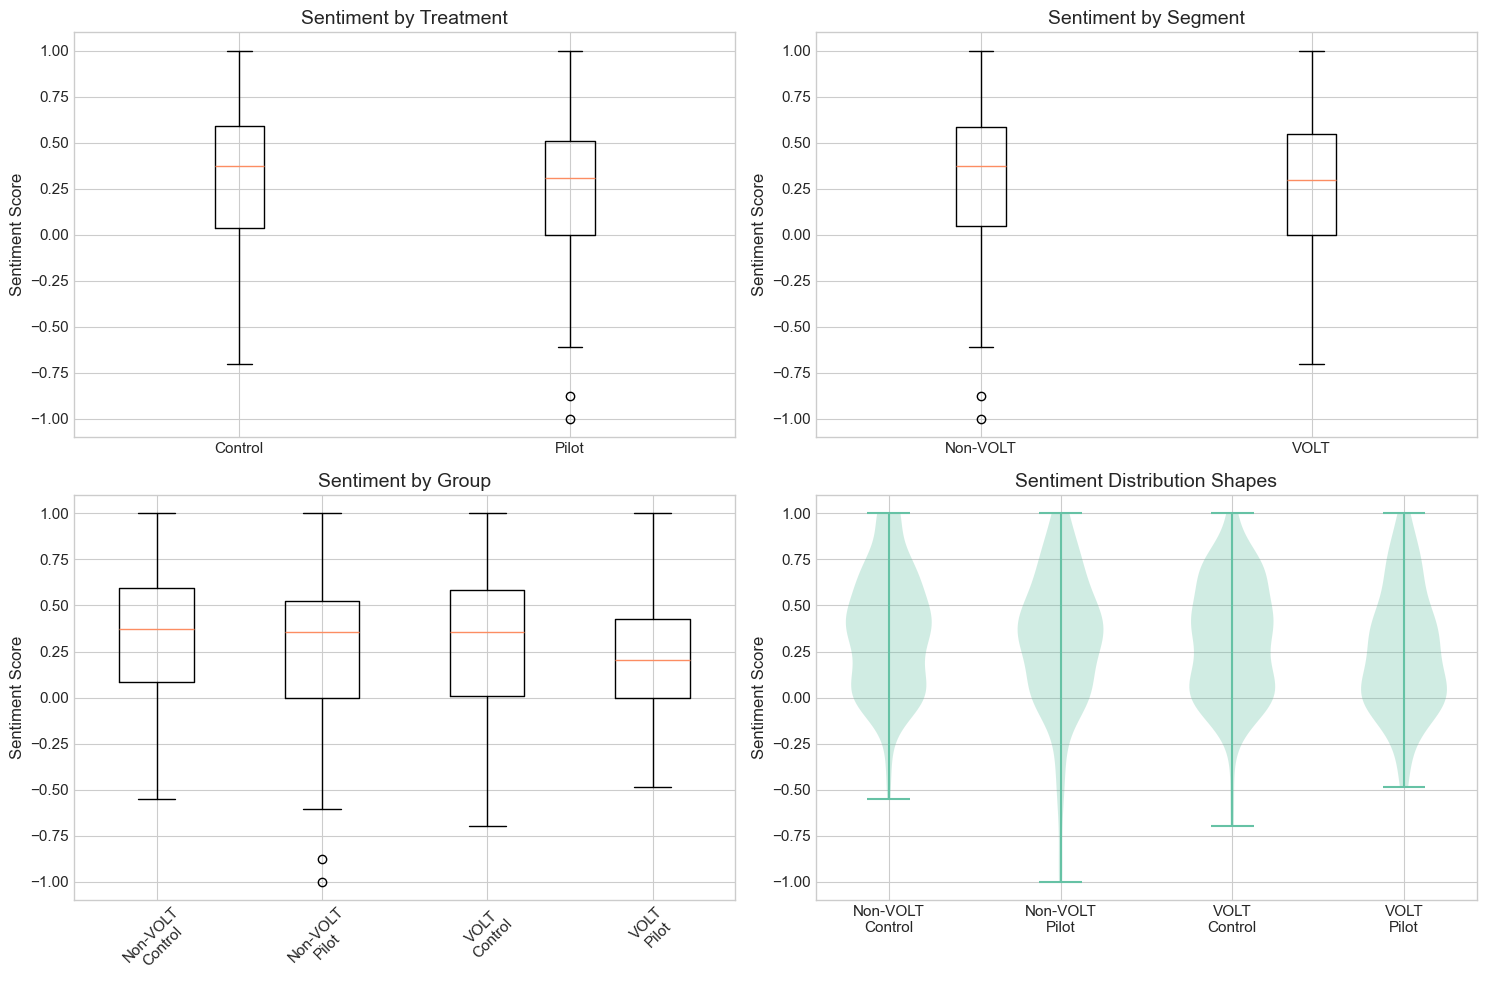

In [16]:
# Sentiment distribution visualisations

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Treatment comparison
treatment_data = [df_with_sentiment[df_with_sentiment['treatment'] == 'control']['sentiment_textblob'].dropna(),
                  df_with_sentiment[df_with_sentiment['treatment'] == 'pilot']['sentiment_textblob'].dropna()]
axes[0,0].boxplot(treatment_data, labels=['Control', 'Pilot'])
axes[0,0].set_title('Sentiment by Treatment')
axes[0,0].set_ylabel('Sentiment Score')

# Segment comparison
segment_data = [df_with_sentiment[df_with_sentiment['segment'] == 'Non-VOLT']['sentiment_textblob'].dropna(),
                df_with_sentiment[df_with_sentiment['segment'] == 'VOLT']['sentiment_textblob'].dropna()]
axes[0,1].boxplot(segment_data, labels=['Non-VOLT', 'VOLT'])
axes[0,1].set_title('Sentiment by Segment')
axes[0,1].set_ylabel('Sentiment Score')

# All four groups
group_order = ['Non-VOLT_control', 'Non-VOLT_pilot', 'VOLT_control', 'VOLT_pilot']
group_data = []
for group in group_order:
    group_sentiment = df_with_sentiment[df_with_sentiment['group'] == group]['sentiment_textblob'].dropna()
    group_data.append(group_sentiment)

axes[1,0].boxplot(group_data, labels=['Non-VOLT\nControl', 'Non-VOLT\nPilot', 'VOLT\nControl', 'VOLT\nPilot'])
axes[1,0].set_title('Sentiment by Group')
axes[1,0].set_ylabel('Sentiment Score')
axes[1,0].tick_params(axis='x', rotation=45)

# Violin plots for distribution shapes
parts = axes[1,1].violinplot(group_data, positions=range(1, len(group_data)+1))
axes[1,1].set_title('Sentiment Distribution Shapes')
axes[1,1].set_ylabel('Sentiment Score')
axes[1,1].set_xticks(range(1, len(group_data)+1))
axes[1,1].set_xticklabels(['Non-VOLT\nControl', 'Non-VOLT\nPilot', 'VOLT\nControl', 'VOLT\nPilot'])

plt.tight_layout()
save_figure('sentiment_distributions_by_groups')
plt.show()

Saved: ../outputs/figures/topic_sentiment_heatmap.png


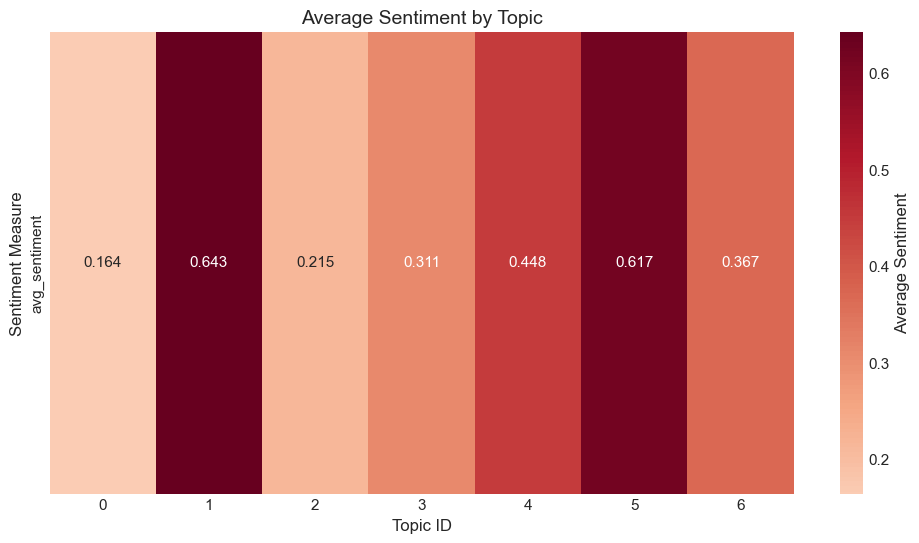

In [17]:
# Create topic-sentiment correlation heatmap

# Create correlation matrix between topics and sentiment
topic_sentiment_matrix = meaningful_docs.pivot_table(
    values='sentiment_textblob', 
    index='assigned_topic', 
    aggfunc=['mean', 'count']
).round(3)

# Flatten column names
topic_sentiment_matrix.columns = ['avg_sentiment', 'doc_count']

# Create heatmap data - use average sentiment per topic
heatmap_data = topic_sentiment_matrix[['avg_sentiment']].T

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='RdBu_r', center=0, 
            fmt='.3f', cbar_kws={'label': 'Average Sentiment'})
plt.title('Average Sentiment by Topic')
plt.xlabel('Topic ID')
plt.ylabel('Sentiment Measure')
save_figure('topic_sentiment_heatmap')
plt.show()

## 5. Results Compilation and Data Export

In [18]:
print_section_header("Compiling Sentiment Analysis Results")

# Compile treatment effect results
treatment_effects = {
    'overall': {
        'control_mean': control_sentiment.mean(),
        'pilot_mean': pilot_sentiment.mean(),
        'difference': pilot_sentiment.mean() - control_sentiment.mean(),
        'p_value': treatment_comparison['p_value'],
        'cohens_d': treatment_comparison['cohens_d'],
        'significant': treatment_comparison['significant']
    },
    'non_volt': {
        'control_mean': non_volt_comparison['group1_mean'],
        'pilot_mean': non_volt_comparison['group2_mean'],
        'difference': non_volt_comparison['group2_mean'] - non_volt_comparison['group1_mean'],
        'p_value': non_volt_comparison['p_value'],
        'cohens_d': non_volt_comparison['cohens_d']
    },
    'volt': {
        'control_mean': volt_comparison['group1_mean'],
        'pilot_mean': volt_comparison['group2_mean'],
        'difference': volt_comparison['group2_mean'] - volt_comparison['group1_mean'],
        'p_value': volt_comparison['p_value'],
        'cohens_d': volt_comparison['cohens_d']
    }
}

# Compile topic-sentiment co-occurrence
topic_sentiment_cooccurrence = {
    'topic_sentiment_stats': topic_sentiment_stats,
    'most_positive_topics': top_positive_topics,
    'most_negative_topics': top_negative_topics,
    'most_common_topics': most_common_topics
}

print("Results compiled successfully")
print(f"Enhanced dataframe: {len(df_with_sentiment)} documents")
print(f"Treatment effects calculated for: overall, Non-VOLT, VOLT segments")
print(f"Topic-sentiment analysis: {len(unique_topics)} topics analysed")

# Save enhanced dataframe for modeling notebook
save_processed_data(df_with_sentiment, 'sentiment_data.csv')


COMPILING SENTIMENT ANALYSIS RESULTS
Results compiled successfully
Enhanced dataframe: 422 documents
Treatment effects calculated for: overall, Non-VOLT, VOLT segments
Topic-sentiment analysis: 7 topics analysed
Saved processed data: ../data/processed/sentiment_data.csv
